<a href="https://colab.research.google.com/github/roxyrong/ml-esg-3/blob/main/eng_baseline.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [3]:
from google.colab import drive
drive.mount("/content/drive")

Mounted at /content/drive


In [7]:
%cd drive/MyDrive/github/ml-esg-3

/content/drive/MyDrive/github/ml-esg-3


In [25]:
%%capture

!pip install -U ipython-autotime sentence-transformers pyarrow tqdm ipywidgets tabulate

In [80]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from tqdm.notebook import tqdm_notebook
from sentence_transformers import SentenceTransformer

from sklearn.model_selection import StratifiedKFold
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import precision_score, recall_score, f1_score, confusion_matrix

tqdm_notebook.pandas()

In [39]:
data_df = pd.read_parquet("dataset/train_df.parquet")

In [40]:
data_df = data_df[data_df["language"] == "English"]

In [15]:
model = SentenceTransformer('sentence-transformers/sentence-t5-base')

.gitattributes:   0%|          | 0.00/1.18k [00:00<?, ?B/s]

1_Pooling/config.json:   0%|          | 0.00/190 [00:00<?, ?B/s]

2_Dense/config.json:   0%|          | 0.00/115 [00:00<?, ?B/s]

pytorch_model.bin:   0%|          | 0.00/2.36M [00:00<?, ?B/s]

rust_model.ot:   0%|          | 0.00/2.36M [00:00<?, ?B/s]

README.md:   0%|          | 0.00/2.01k [00:00<?, ?B/s]

config.json:   0%|          | 0.00/1.39k [00:00<?, ?B/s]

config_sentence_transformers.json:   0%|          | 0.00/122 [00:00<?, ?B/s]

convert.ipynb:   0%|          | 0.00/74.6k [00:00<?, ?B/s]

convert_to_fp16.py:   0%|          | 0.00/198 [00:00<?, ?B/s]

pytorch_model.bin:   0%|          | 0.00/219M [00:00<?, ?B/s]

sentence_bert_config.json:   0%|          | 0.00/53.0 [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/1.79k [00:00<?, ?B/s]

spiece.model:   0%|          | 0.00/792k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.39M [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/1.92k [00:00<?, ?B/s]

modules.json:   0%|          | 0.00/461 [00:00<?, ?B/s]

In [41]:
data_df["sentence"] = data_df["title"] + " || " + data_df["content"]
sentences = list(data_df["sentence"])

In [42]:
embeddings = model.encode(sentences)

In [43]:
data_df["embedding"] = list(embeddings)

# Baseline

In [77]:
accuracys = []
precisions = []
recalls = []
f1s = []

skf = StratifiedKFold(n_splits=5)
for train_idx, valid_idx in skf.split(data_df["embedding"], data_df["impact_length_idx"]):
  X_train = np.stack(data_df.loc[train_idx]["embedding"])
  y_train = np.stack(data_df.loc[train_idx]["impact_length_idx"])
  X_valid = np.stack(data_df.loc[valid_idx]["embedding"])
  y_valid = np.stack(data_df.loc[valid_idx]["impact_length_idx"])
  lr = LogisticRegression(random_state=314,
                          C=0.5,
                          class_weight="balanced").fit(X_train, y_train)

  y_pred = lr.predict(X_valid)
  accuracy = lr.score(X_valid, y_valid)
  precision = precision_score(y_valid, y_pred, average='weighted')
  recall = recall_score(y_valid, y_pred, average='weighted')
  f1 = f1_score(y_valid, y_pred, average='weighted')

  accuracys.append(accuracy)
  precisions.append(precision)
  recalls.append(recall)
  f1s.append(f1)

print("accuracy:", np.mean(accuracys))
print("precision:",np.mean(precisions))
print("recall:", np.mean(recalls))
print("f1:", np.mean(f1s))

accuracy: 0.5064220183486239
precision: 0.5365710076204594
recall: 0.5064220183486239
f1: 0.5118021415233934


Text(0.5, 1.0, 'Confusion Matrix')

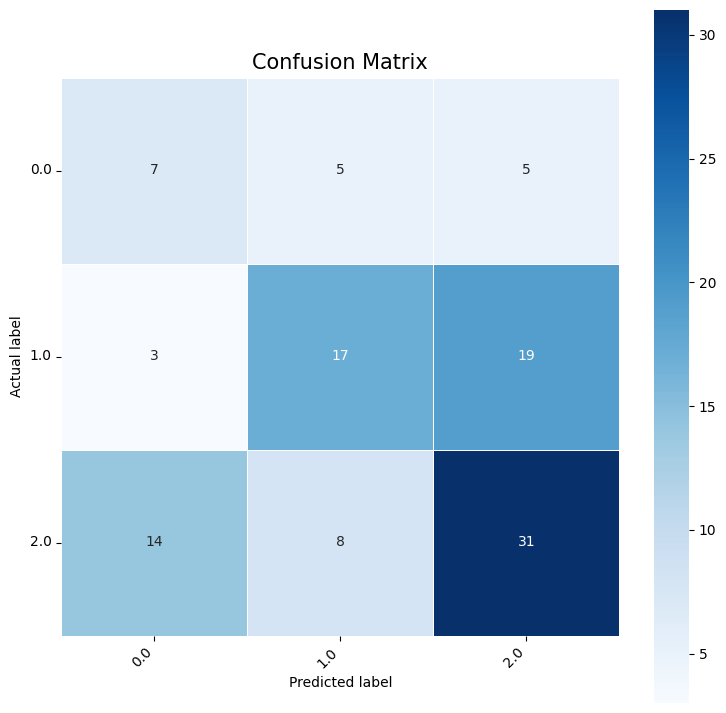

In [81]:
confusion_matrix = confusion_matrix(y_valid, y_pred)

plt.figure(figsize=(9,9))
sns.heatmap(confusion_matrix, annot=True, fmt="0", linewidths=.5,
            square = True, cmap = "Blues");
plt.ylabel("Actual label")
plt.xlabel("Predicted label")
plt.xticks(ticks=np.arange(3) + 0.5, labels=lr.classes_, rotation=45, ha='right')
plt.yticks(ticks=np.arange(3) + 0.5, labels=lr.classes_, rotation=0)

all_sample_title = "Confusion Matrix"
plt.title(all_sample_title, size = 15)